In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import os, subprocess
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# Location where original video is stored and segmented video location
segment_loc = "/Users/sharingan/Documents/IEMOCAP/sentences/avi/"
original_vid_loc = "/Users/sharingan/Documents/IEMOCAP/avi/DivX/"

# Where you want to store input processed frames
frames_loc = "/Users/sharingan/Documents/IEMOCAP/frames_for_CNN/"

# Location where the datafile is located
datafile_loc = "/Users/sharingan/Documents/IEMOCAP/EmoEvaluation/"
frames_no_stripes_loc = "/Users/sharingan/Documents/IEMOCAP/Frames_no_stripes/"

In [3]:
# Select videos with script (We are not using impro videos)
all_vid_names = subprocess.check_output(["ls",original_vid_loc]).split()
all_names = [x[:-4] for x in all_vid_names]
script_vid_names = [x for x in all_names if x.split('_')[1][0] == 's'] 
print script_vid_names

['Ses01F_script01_1', 'Ses01F_script01_2', 'Ses01F_script01_3', 'Ses01F_script02_1', 'Ses01F_script02_2', 'Ses01F_script03_1', 'Ses01F_script03_2', 'Ses01M_script01_1', 'Ses01M_script01_2', 'Ses01M_script01_3', 'Ses01M_script02_1', 'Ses01M_script02_2', 'Ses01M_script03_1', 'Ses01M_script03_2']


# EXTRACTING FRAMES AND SAVING THEM IN SCRIPT-WISE FASHION

In [102]:
# creating directories for frames on the basis of scpritps
# creating subdirectories with 4 emotions

def create_directory(directory_name):
    os.system('mkdir ' + frames_loc + directory_name)

# selected_scripts = ['script01', 'script02', 'script03']
selected_scripts = ['test', 'test2', 'test3']
# selected_emotions = ['ang', 'hap', 'sad', 'neu']
selected_emotions = ['ang', 'neu']
for script in selected_scripts:
    create_directory(script)
    for emo in selected_emotions:
        create_directory(script + "/" + emo)

Only needed to execute once

In [5]:
# def extract_videos_for_CNN(video_input_file_path, script, emo, segment_name):
#     print '\n Extracting frames from video: ', video_input_file_path
#     vidcap = cv2.VideoCapture(video_input_file_path)
#     success, image = vidcap.read()
#     features = []
#     success = True
#     count = 0
#     while success:
# #         plt.imshow(image, cmap='gray')
# #         plt.xticks([]),plt.yticks([])  # to hide tick values on X and Y axis
# #         plt.show()
#         success, image = vidcap.read()
# #         print('Read a new frame: ', success)
#         if success:
#             image = image[120:360, 0:720]
#             image = cv2.resize(image, (480, 480), interpolation=cv2.INTER_AREA)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# #             channels = image.shape[2]
# #             print image.shape
# #             for channel in range(channels):
# #                 features.append(image[:, :, channel])
#             count = count + 1
#             loc = frames_loc + script + '/' + emo + '/' + segment_name + '_' + str(count) + '.jpg'
#             print cv2.imwrite(loc, image),
        

# for name in script_vid_names:
# #     print "\n Extracting frames from ", name
#     txt_file_name = name + '.txt'
#     with open(datafile_loc + txt_file_name) as f:
#         data = f.readlines()
#     data = iter(data)
#     try:
#         for line in data:
#             if line != '\n':
#                 continue;
#             line = next(data)
#             segment_name = line.split()[3]
#             emotion = line.split()[4]
#             script = segment_name.split('_')[1]
#             this_segment_loc = segment_loc + name + '/' + segment_name + '.avi'
#             if emotion in selected_emotions:
#                 extract_videos_for_CNN(this_segment_loc, script, emotion, segment_name)
            
#     except(StopIteration):
#         pass

# CNN

In [112]:
#batch size
bs = 4

In [115]:
def CNN_model():
    model = Sequential()
    # define CNN model
    model.add(Conv2D(bs, (3, 3), activation = 'relu' ,input_shape = (50,50,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(selected_emotions), activation = 'softmax'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model
# print model.summary()

In [116]:
def generate_train(directory):
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(directory,
                                                        target_size=(50, 50),
                                                        batch_size=bs,
                                                        class_mode='categorical',
                                                        color_mode = 'grayscale')
    return train_generator

def generate_test(directory):
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(directory,
                                                            target_size=(50, 50),
                                                            batch_size=bs,
                                                            class_mode='categorical',
                                                            color_mode='grayscale')
    return test_generator

In [117]:
kf = KFold(n_splits=len(selected_scripts))
kf = kf.split(selected_scripts)

# Calculating class weights
for train, test in kf:
    y_train = []
    for t in train:
        train_generator = generate_train(frames_loc + selected_scripts[t])
        y_train.extend(train_generator.classes)
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print class_weight_dict

Found 645 images belonging to 2 classes.
Found 1048 images belonging to 2 classes.
{0: 1.1347184986595173, 1: 0.8938753959873285}
Found 683 images belonging to 2 classes.
Found 1048 images belonging to 2 classes.
{0: 1.2879464285714286, 1: 0.8172804532577904}
Found 683 images belonging to 2 classes.
Found 645 images belonging to 2 classes.
{0: 1.0849673202614378, 1: 0.9273743016759777}


In [118]:
# create training and testing set

kf = KFold(n_splits=len(selected_scripts))
kf = kf.split(selected_scripts)

# Each iteration represents one fold
for train, test in kf:
    print "++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"
    print "++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"
    # New model for every fold
    model = CNN_model()
    
    # Calculating class weights
    y_train = []
    for t in train:
        train_generator = generate_train(frames_loc + selected_scripts[t])
        y_train.extend(train_generator.classes)
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    class_weights = dict(enumerate(class_weights))
    
    # Validation data
    for t in test:
        test_generator = generate_test(frames_loc + selected_scripts[t])
    
    # Fit training data
    for t in train:
        train_generator = generate_train(frames_loc + selected_scripts[t])
        
        model.fit_generator(
            train_generator,
            steps_per_epoch=np.math.ceil(float(train_generator.samples)/float(train_generator.batch_size)),
            class_weight = class_weights,
            epochs=10,
            validation_data=test_generator,
            validation_steps=np.math.ceil(float(test_generator.samples)/float(test_generator.batch_size)))
        
    class_labels = list(test_generator.class_indices.keys())
    predictions = model.predict_generator(test_generator, np.math.ceil(float(test_generator.samples)/float(test_generator.batch_size)))
    predicted_classes = np.argmax(predictions, axis=1)
    
    # results
    report = metrics.classification_report(test_generator.classes, predicted_classes, target_names=class_labels)
    
    # confusion matrix
    confusion_mat = metrics.confusion_matrix(test_generator.classes, predicted_classes)
    
    print report  
    print class_labels
    print confusion_mat
    
    with open("results.txt", "a") as f:
        print >> f, report
        print >> f, class_labels
        print >> f, confusion_mat

#     # making directories and storing training and testing samples
#     os.system("rm -rf train")
#     os.system("rm -rf test")
#     os.system("mkdir train")
#     os.system("mkdir test")
    
#     print "Creating TRAINING SET"
#     dest = " ./train/"
#     for dr in train:
#         src = frames_loc + selected_scripts[dr] + '/'
#         print os.system("rsync -a " + src + dest)
    
#     print "Creating TESTING SET"
#     dest = " ./test/"
#     for dr in test:
#         src = frames_loc + selected_scripts[dr] + '/'
#         print os.system("rsync -a " + src + dest)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Found 645 images belonging to 2 classes.
Found 1048 images belonging to 2 classes.
Found 683 images belonging to 2 classes.
Found 645 images belonging to 2 classes.
Epoch 1/10
162/162 [==============================] - 6s 37ms/step - loss: 0.7105 - acc: 0.5262 - val_loss: 0.7287 - val_acc: 0.3939
Epoch 2/10
162/162 [==============================] - 4s 27ms/step - loss: 0.5565 - acc: 0.6867 - val_loss: 0.6861 - val_acc: 0.6061
Epoch 3/10
162/162 [==============================] - 4s 27ms/step - loss: 0.3369 - acc: 0.9306 - val_loss: 0.6738 - val_acc: 0.6061
Epoch 4/10
162/162 [==============================] - 4s 27ms/step - loss: 0.2470 - acc: 0.9784 - val_loss: 0.6708 - val_acc: 0.6061
Epoch 5/10
162/162 [==============================] - 4s 27ms/step - loss: 0.1995 - acc: 0.9938 - val_loss: 0.6786 - val_acc: 0.6061
Epoch 6/10
162/162 [========================

Epoch 10/10
171/171 [==============================] - 6s 33ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 2.0524 - val_acc: 0.6155
Found 645 images belonging to 2 classes.
Epoch 1/10
162/162 [==============================] - 6s 36ms/step - loss: 0.1804 - acc: 0.9475 - val_loss: 3.0923 - val_acc: 0.6164
Epoch 2/10
162/162 [==============================] - 6s 34ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 4.1297 - val_acc: 0.6164
Epoch 3/10
162/162 [==============================] - 5s 34ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 4.1050 - val_acc: 0.6145
Epoch 4/10
162/162 [==============================] - 5s 34ms/step - loss: 8.9479e-04 - acc: 1.0000 - val_loss: 4.2958 - val_acc: 0.6145
Epoch 5/10
162/162 [==============================] - 6s 34ms/step - loss: 7.1749e-04 - acc: 1.0000 - val_loss: 3.9921 - val_acc: 0.6164
Epoch 6/10
162/162 [==============================] - 6s 34ms/step - loss: 4.6168e-04 - acc: 1.0000 - val_loss: 4.5840 - val_acc: 0.6126
Epoch 7/10
162/

(4, 50, 50, 1)


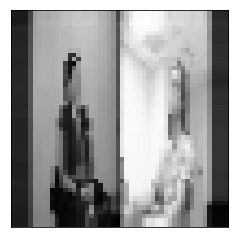

In [93]:
img, y = next(train_generator)
print img.shape
img = (img[0]).reshape((50, 50))

plt.imshow(img, cmap='gray')
plt.xticks([]),plt.yticks([])  # to hide tick values on X and Y axis
plt.show()